In [209]:
import os
import requests
import pandas as pd
from pyspark.sql import SparkSession
from tmlt.analytics.privacy_budget import PureDPBudget
from tmlt.analytics.query_builder import QueryBuilder
from tmlt.analytics.session import Session
from pyspark.sql.functions import desc, asc

In [210]:
import warnings
warnings.filterwarnings('ignore')

### Setup

In [211]:
spark = SparkSession.builder.getOrCreate()

In [212]:
spark = (
    SparkSession.builder
    .config("spark.driver.extraJavaOptions", "-Dio.netty.tryReflectionSetAccessible=true")
    .config("spark.executor.extraJavaOptions", "-Dio.netty.tryReflectionSetAccessible=true")
    .getOrCreate()
)

In [213]:
r = requests.get(
    'https://tumult-public.s3.amazonaws.com/library-members.csv',
)

with open("members.csv", "w") as f:
    f.write(r.text)
members_df = spark.read.csv("members.csv", header=True, inferSchema=True)

### Creating a Session with:
    
1. **Privacy Budget**: Specifies what privacy guarantee 
2. **Source_id**: Identifier for the DataFrame

In [214]:
session = Session.from_dataframe(
    privacy_budget=PureDPBudget(3),
    source_id="members",
    dataframe=members_df
)

### Evaluating queries in a Session

### Counting

In [220]:
total_count = members_df.count()
print(total_count)

54217


### Group-by queries

In [16]:
from tmlt.analytics.keyset import KeySet

In [74]:
edu_levels = KeySet.from_dict({
    "education_level": [
        "up-to-high-school",
        "high-school-diploma",
        "bachelors-associate",
        "masters-degree",
        "doctorate-professional",
    ]
})

In [75]:
session = Session.from_dataframe(
    privacy_budget=PureDPBudget(epsilon=float('inf')),
    source_id="members",
    dataframe=members_df,
)

###  Impact of clamping 

- As suggested by their name, the input data will be clamped within these bounds.
- The amount of perturbation in the data will (typically) increase with the size of the clamping bounds.

**Choice of clamping bounds**:  In those cases, it is often a good idea to choose clamping bounds that aren’t absolute limits over the data range, but are such that most values would fall within these bounds

**Note**: Clamping it can often make your data analysis more robust: it reduces the contribution of outlier data points, which could otherwise have an outsized influence on the results.

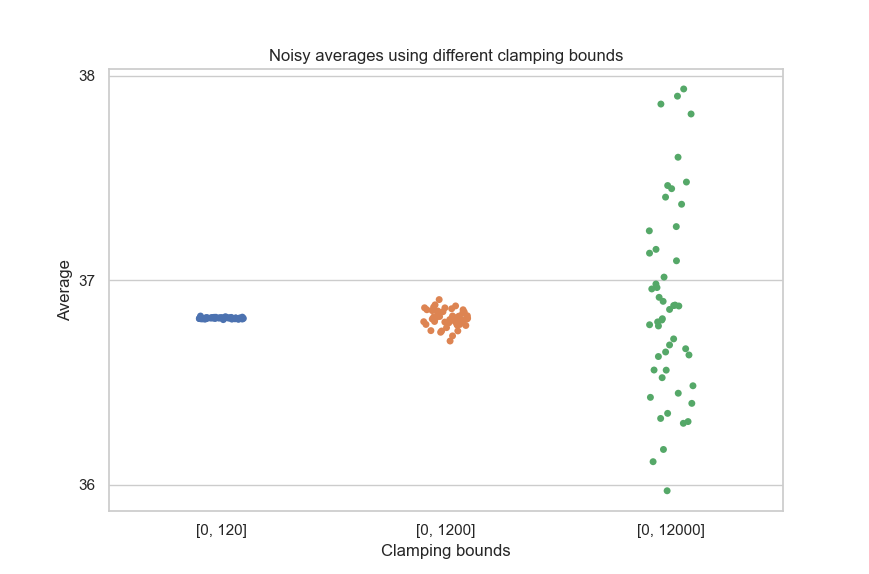

###  Impact of privacy budget 

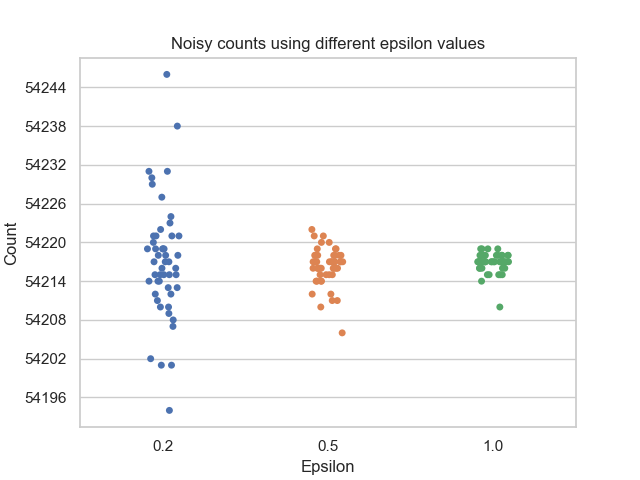

In [242]:
# configuring a session
session = Session.from_dataframe(
    privacy_budget=PureDPBudget(epsilon=float('inf')),
    source_id="members",
    dataframe=members_df,
)

# group by query 
edu_sum_age_query = (
    QueryBuilder("members")
    .groupby(edu_levels)
    .sum("age", low=0, high=120) # clamping
)

# setting the privacy budget
edu_sum_ages = session.evaluate(
    edu_sum_age_query,
    privacy_budget=PureDPBudget(1),
)

# edu_sum_ages.sort("age_sum").show(truncate=False)

In [243]:
def visualise(perturbed_df, true_df): 
    pd_perturbed_age_sum = edu_sum_ages.toPandas() #.rename(columns={'sum(age)': 'age_sum'})
    pd_perturbed_age_sum['state'] = ['noisy']*pd_perturbed_age_sum.shape[0]

    pd_true_age_sum = true_df.groupBy('education_level').sum('age').sort(asc("sum(age)"))
    pd_true_age_sum = pd_true_age_sum.toPandas().rename(columns={'sum(age)': 'age_sum'})
    pd_true_age_sum['state'] = ['original']*pd_true_age_sum.shape[0]
    pd_true_age_sum

    true_perturbed_age_sum = pd_perturbed_age_sum.append(pd_true_age_sum, ignore_index=True)
    true_perturbed_age_sum
    
    sns.catplot(x="education_level", y="age_sum", hue="state", kind="bar", data=true_perturbed_age_sum)
    plt.xticks(rotation=45)
    return plt 


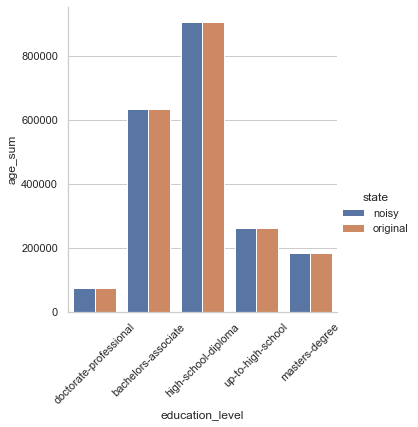

In [244]:
visualise(edu_sum_ages, members_df).show()

 ##  Impact of the privacy budget, clamping bound and dataset size

Students --> Firms 

Education Level --> Sectors 

Age --> Number of researchers, amount

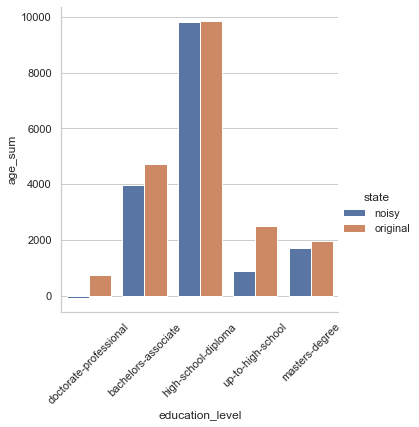

+--------------------+-----+
|     education_level|count|
+--------------------+-----+
| high-school-diploma|  222|
| bachelors-associate|  103|
|   up-to-high-school|  125|
|      masters-degree|   36|
|doctorate-profess...|   14|
+--------------------+-----+



In [282]:
# knobs to handle privacy and utility trade-off for sum query

# 1. sampling data from 54217 records 
SAMPLE_SIZE = 500 # (FIRMS)

# 2. privacy budget for the query -- epsilon
PRIVACY_BUDGET = 1 

# 3. low and high clamping bounds
CLAMPING_BOUNDS = [0, 1000] # (#REARCHERS, AMOUNT)

sampled_data = members_df.limit(SAMPLE_SIZE) 

# each individual has an influence on at most one bucket (SECTORS)
edu_levels = KeySet.from_dict({
    "education_level": [
        "up-to-high-school",
        "high-school-diploma",
        "bachelors-associate",
        "masters-degree",
        "doctorate-professional",
    ]
})

session = Session.from_dataframe(
    # adding laplacian noise 
    privacy_budget=PureDPBudget(epsilon=float('inf')), # privacy budget for the session
    source_id="members",
    dataframe=sampled_data
)

# group by query 
edu_sum_age_query = (
    QueryBuilder("members")
    .groupby(edu_levels)
    .sum("age", low=CLAMPING_BOUNDS[0], high=CLAMPING_BOUNDS[1]) 
)

# privacy budget for the query
edu_sum_ages = session.evaluate(
    edu_sum_age_query,
    privacy_budget=PureDPBudget(PRIVACY_BUDGET), 
)

# show visualisations
visualise(edu_sum_ages, sampled_data).show()
sampled_data.groupby(sampled_data.education_level).count().show()